## 1. Orthogonal Procrustes problem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


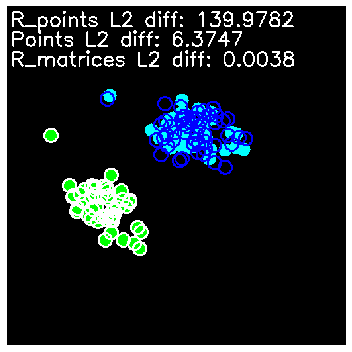

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Step1: Create an initial set of points.
#        Apply a rotation matrix to the initial point to create a rotation set.
#        Also add some noise to the rotation point.
pts = np.random.multivariate_normal([150, 300], [[1024, 512], [512, 1024]], 50)

rmat = cv2.getRotationMatrix2D((0, 0), 30, 1)[:, :2]
rpts = np.matmul(pts, rmat.transpose())

rpts_noise = rpts + np.random.multivariate_normal([0, 0], [[200, 0], [0, 200]], len(pts))

# Step2: Use SVD(Singular Value Decomposition) and
#        obtain estimated values of rotation matrix
#        to solve orthogonal Procrustes problem.
M = np.matmul(pts.transpose(), rpts_noise)

sigma, u, v_t = cv2.SVDecomp(M)

rmat_est = np.matmul(v_t, u).transpose()

# Step3: Now let's use the estimated rotation matrix
#        to see how well the estimate was made.
#        To do this, calculate inverse rotation matrix and
#        multiply it by the points previously rotated.
#        Euclidean distance(L2) between the rotated points with or without noise is then calculated.
#        Distance between the inversely rotated point and the point in initial position, and
#        distance between the initial rotation matrix and its estimate, is also calculated.
res, rmat_inv = cv2.invert(rmat_est)
assert res != 0
pts_est = np.matmul(rpts, rmat_inv.transpose())

rpts_err = cv2.norm(rpts, rpts_noise, cv2.NORM_L2)
pts_err = cv2.norm(pts_est, pts, cv2.NORM_L2)
rmat_err = cv2.norm(rmat, rmat_est, cv2.NORM_L2)

# Step4: Initial points can be represented by a circle filled with green and
#        rotation points by a circle filled with yellow.
#        Opposite rotated points can be represented by a thin white circle and
#        rotated points with noise by a thin red circle.
#        It then shows information about L2 difference between the points and the matrix.
def draw_pts(image, points, color, thickness=cv2.FILLED):
    for pt in points:
        cv2.circle(img, tuple([int(x) for x in pt]), 10, color, thickness)

img = np.zeros([512, 512, 3])

draw_pts(img, pts, (0, 255, 0))
draw_pts(img, pts_est, (255, 255, 255), 2)
draw_pts(img, rpts, (0, 255, 255))
draw_pts(img, rpts_noise, (0, 0, 255), 2)

cv2.putText(img, 'R_points L2 diff: %.4f' % rpts_err, (5, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(img, 'Points L2 diff: %.4f' % pts_err, (5, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(img, 'R_matrices L2 diff: %.4f' % rmat_err, (5, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

cv2.imshow('Points', img)
cv2.waitKey()
cv2.destroyAllWindows()

#image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,5))
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(img)
plt.show()

## 2. Rank-constrained matrix approximation

In [2]:
import cv2
import numpy as np

A = np.random.randn(10, 10)

w, u, v_t = cv2.SVDecomp(A)

rank = 5
w[rank:,0] = 0
B = u @ np.diag(w[:,0]) @ v_t

print('Rank before:', np.linalg.matrix_rank(A))
print('Rank after:', np.linalg.matrix_rank(B))
print('\nNorm before:', cv2.norm(A))
print('Norm after:', cv2.norm(B))

Rank before: 10
Rank after: 5

Norm before: 9.653914143018158
Norm after: 9.22845674238781


## 3. Principal Component Analysis(PCA)

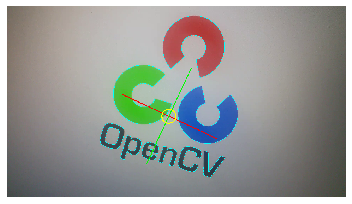

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Step1: Define a function which applies PCA to contour and determines a new base.
def contours_pca(contours):
    # join all contours points into the single matrix and remove unit dimensions
    cnt_pts = np.vstack(contours).squeeze().astype(np.float32)

    mean, eigvec = cv2.PCACompute(cnt_pts, None)

    center = mean.squeeze().astype(np.int32)
    delta = (150*eigvec).astype(np.int32)
    return center, delta

# Step2: Define a function that displays the results of applying PCA to contour.
def draw_pca_results(image, contours, center, delta):
    cv2.drawContours(image, contours, -1, (255, 255, 0))

    cv2.line(image, tuple((center + delta[0])), 
                    tuple((center - delta[0])), 
                    (0, 255, 0), 2)

    cv2.line(image, tuple((center + delta[1])), 
                    tuple((center - delta[1])), 
                    (0, 0, 255), 2)

    cv2.circle(image, tuple(center), 20, (0, 255, 255), 2)
    
cap = cv2.VideoCapture("./data/opencv_logo.mp4")

# Step3: Find contours in each frame and apply PCA.
while True:
    status_cap, frame = cap.read()
    if not status_cap:
        break
    
    frame = cv2.resize(frame, (0, 0), frame, 0.5, 0.5)
    edges = cv2.Canny(frame, 250, 150)
    
    _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours):
        center, delta = contours_pca(contours)
        draw_pca_results(frame, contours, center, delta)
        
    cv2.imshow('PCA', frame)
    if cv2.waitKey(50) == 27: #ESC
        break

cv2.destroyAllWindows()
image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()

## 4. Solving systems of linear equations (including under- and overdetermined)

In [4]:
import cv2
import numpy as np

# Linear equation system
N = 10
A = np.random.randn(N,N)
while np.linalg.matrix_rank(A) < N:
    A = np.random.randn(N,N)
x = np.random.randn(N,1)
b = A @ x

# Solving linear equation system
ok, x_est = cv2.solve(A, b)
print('Solved:', ok)
if ok:
    print('Residual:', cv2.norm(b - A @ x_est))
    print('Relative error:', cv2.norm(x_est - x) / cv2.norm(x))
    
# Overdetermined linear equation
N = 10
A = np.random.randn(N*2,N)
while np.linalg.matrix_rank(A) < N:
    A = np.random.randn(N*2,N)
x = np.random.randn(N,1)
b = A @ x

# Solving overdetermined linear equation
ok, x_est = cv2.solve(A, b, flags=cv2.DECOMP_NORMAL)
print('\nSolved overdetermined system:', ok)
if ok:
    print('Residual:', cv2.norm(b - A @ x_est))
    print('Relative error:', cv2.norm(x_est - x) / cv2.norm(x))
    
# Undetermined linear equation with one or more answers
N = 10
A = np.random.randn(N,N*2)
x = np.random.randn(N*2,1)
b = A @ x

# Solving undetermined linear equation
# Find solution with a minimum norm
w, u, v_t = cv2.SVDecomp(A, flags=cv2.SVD_FULL_UV)
mask = w > 1e-6
w[mask] = 1 / w[mask]
w_pinv = np.zeros((A.shape[1], A.shape[0]))
w_pinv[:N,:N] = np.diag(w[:,0])
A_pinv = v_t.T @ w_pinv @ u.T
x_est = A_pinv @ b

print('\nSolved underdetermined system')
print('Residual:', cv2.norm(b - A @ x_est))
print('Relative error:', cv2.norm(x_est - x) / cv2.norm(x))

Solved: True
Residual: 2.269856336252304e-15
Relative error: 7.520669391271895e-16

Solved overdetermined system: True
Residual: 5.444622457435257e-15
Relative error: 1.0907749991368847e-15

Solved underdetermined system
Residual: 2.861447738143812e-14
Relative error: 0.7269456387713616


## 5. Solving polynomial equations

In [5]:
import cv2
import numpy as np

# Fourth polynomial
N = 4
coeffs = np.random.randn(N+1,1)

# Find all root values in complex domain
retval, roots = cv2.solvePoly(coeffs)

for i in range(N):
    print('Root', roots[i],'residual:', 
          np.abs(np.polyval(coeffs[::-1], roots[i][0][0]+1j*roots[i][0][1])))

Root [[0.66718396 0.92813692]] residual: [2.22044605e-16]
Root [[ 0.66718396 -0.92813692]] residual: [2.22044605e-16]
Root [[-1.46982646  0.        ]] residual: [4.4408921e-16]
Root [[-6.10930249  0.        ]] residual: [1.50990331e-14]


## 6. Linear programming using Simplex method

In [6]:
import cv2
import numpy as np

m = 10
n = 10
constrains_mat = np.random.randn(m, n+1)
weights = np.random.randn(1, n)

solution = np.array((n, 1), np.float64) # error in np.float32
res = cv2.solveLP(weights, constrains_mat, solution)

if res == cv2.SOLVELP_SINGLE:
    print('The problem has the one solution')
elif res == cv2.SOLVELP_MULTI:
    print('The problem has the multiple solutions')
elif res == cv2.SOLVELP_UNBOUNDED:
    print('The solution is unbounded')
elif res == cv2.SOLVELP_UNFEASIBLE:
    print('The problem doesnt\'t have any solutions')

The problem doesnt't have any solutions
